# Neural Networks in PyTorch
## Part 10: Using CUDA on GPUs
*Yen Lee Loh, 2021-9-8, 2022-11-23*

Training neural networks involves tensor operations that can be implemented efficiently on GPUs.  In this notebook we show:
- how to construct tensors on the CPU and GPU
- how to transfer data between the CPU and GPU
- the GPU is significantly faster.

---
## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
def whatis(a): print("a.device =", a.device, " \ta =", a.tolist())
print ("torch.cuda.is_available() =", torch.cuda.is_available())

torch.cuda.is_available() = True


In [7]:
torch.version.cuda

'11.7'

---
## 2. Simple demo of CPU and GPU usage

In [2]:
a = torch.tensor([[1,2],[3,4]], device='cpu')   # create tensor on CPU
b = torch.tensor([[5,6],[7,8]], device='cpu')
A = a.cuda()  # transfer to GPU ("upload")
B = b.cuda()
C = A + B     # add tensors on GPU
c = C.cpu()   # transfer back to CPU ("download")
whatis (a)    # print everything
whatis (b)
whatis (A)
whatis (B)
whatis (C)
whatis (c)

a.device = cpu  	a = [[1, 2], [3, 4]]
a.device = cpu  	a = [[5, 6], [7, 8]]
a.device = cuda:0  	a = [[1, 2], [3, 4]]
a.device = cuda:0  	a = [[5, 6], [7, 8]]
a.device = cuda:0  	a = [[6, 8], [10, 12]]
a.device = cpu  	a = [[6, 8], [10, 12]]


In [3]:
#======== YOU CANNOT ADD A CPU TENSOR TO A GPU TENSOR DIRECTLY!
A + b

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

---
## 3. Benchmark for speed and accuracy

Construct a large matrix $\mathbf{a}$ with normally distributed elements.  Computes $\mathbf{b} = \mathbf{a}\cdot \mathbf{a}$ and $c = \sum_{ij} b_{ij}$ using the CPU.  Then retry the calculation using the GPU:

In [ ]:
#======== CPU
torchRNG = torch.Generator()
torchRNG.manual_seed(1234567)
a = torch.randn([16384,16384], generator=torchRNG, device='cpu')

tBegin = time.time()
b = torch.matmul (a, a)
c = torch.sum (b)
tEnd = time.time()
tElapsed = tEnd - tBegin

print ('CPU result = {}'.format(c), ' \ttime taken = {:.3} seconds'.format(tElapsed))

In [35]:
#======== GPU
torchRNG = torch.Generator()
torchRNG.manual_seed(1234567)
a = torch.randn([16384,16384], generator=torchRNG, device='cpu')

tBegin = time.time()
A = a.cuda()
tEnd = time.time() ; tElapsed = tEnd - tBegin
print ('Time taken to upload to GPU = {:.3} seconds'.format(tElapsed))

tBegin = time.time()
B = torch.matmul (A, A)
C = torch.sum (B)
tEnd = time.time() ; tElapsed = tEnd - tBegin
print ('Time taken for GPU computation = {:.3} seconds'.format(tElapsed))

tBegin = time.time()
c = C.cpu()
tEnd = time.time() ; tElapsed = tEnd - tBegin
print ('Time taken to download results = {:.3} seconds'.format(tElapsed))

print ('GPU result = {}'.format(c), ' \ttime taken = {:.3} seconds'.format(tElapsed))

Time taken to upload to GPU = 0.124 seconds
Time taken for GPU computation = 0.000396 seconds
Time taken to download results = 2.95 seconds
GPU result = -988810.125  	time taken = 2.95 seconds


There are two important points to note:
- The GPU calculation is significantly faster than the CPU calculation.
- The results differ by a few parts per million, due to slightly different hardware implementations in CPU and GPU!

---
## 4. Mandelbrot

Let

$\qquad\begin{align}
z_0 &= 0 \\
z_{n} &= z_{n-1}^2 + x+iy   \qquad (n=1,2,3,\dotsc,N) \\
\end{align}$

for an array of $I\times J$ values of $(x,y)$.  Plot $\lvert z_N(x,y) \rvert$ for $I=1000$, $J=1000$, $N=1500$ .

In [3]:
imax,jmax,nmax = 1000,1000,1500

In [4]:
xmin,xmax = -2, 1
ymin,ymax = -1.5, 1.5
x = np.linspace (xmin, xmax, imax)
y = np.linspace (ymin, ymax, jmax)
x,y = np.meshgrid(x, y)

CPU calculation: time taken = 13.3 seconds


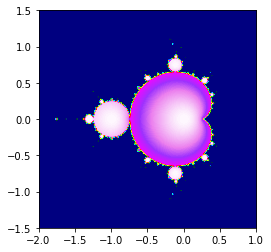

In [5]:
np.seterr (over='ignore',invalid='ignore')

tBegin = time.time()
u = np.zeros_like(x)
v = np.zeros_like(x)
for n in range(nmax):
  w = u*u - v*v + x
  v = 2*u*v + y
  u = w
p = u*u + v*v
tEnd = time.time()
tElapsed = tEnd - tBegin

p=1/(1+p) ; p=np.where(np.isnan(p),0,p)
plt.imshow (p, extent=[xmin,xmax,ymin,ymax], vmin=0, vmax=1, cmap='gist_ncar') ;
print ('CPU calculation: time taken = {:.3} seconds'.format(tElapsed))

GPU calculation: time taken = 1.55 seconds


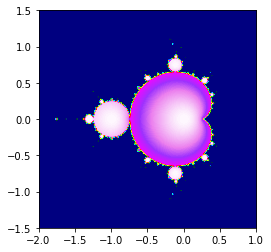

In [6]:
tBegin = time.time()
X = torch.tensor(x).cuda()
Y = torch.tensor(y).cuda()
U = torch.zeros_like(X)  # U is automatically on the GPU
V = torch.zeros_like(X) 
for n in range(nmax):
  W = U*U - V*V + X
  V = 2*U*V + Y
  U = W
P = U*U + V*V
p = P.cpu()
tEnd = time.time()
tElapsed = tEnd - tBegin

p=1/(1+p) ; p=np.where(np.isnan(p),0,p)
plt.imshow (p, extent=[xmin,xmax,ymin,ymax], vmin=0, vmax=1, cmap='gist_ncar') ;
print ('GPU calculation: time taken = {:.3} seconds'.format(tElapsed))

The GPU achieves the same result as the CPU, but in siginificantly less time.

---
## 5. Train a simple neural network using GPU

In [44]:
def train(xnd, ynd, model, loss, optimizer, epochs=10000, lossTarget=0.0001, reportInterval=10):
  model.train()                  # put model in training mode
  for t in range(epochs):      # t is the epoch number
    for bunch in range(100):
      Ynd = model(xnd)             # uppercase Y = model prediction
      F = loss(Ynd,ynd)
      F.backward()
      optimizer.step()
      optimizer.zero_grad()
    F = F.item()
    if t % reportInterval == 0 or t==epochs:
      print('Training epoch {}/{}  \t Loss = {:.4f}'.format(t, epochs, F, F<lossTarget))
    if F<lossTarget: return
  print ('Warning: loss > lossTarget!\n')

In [45]:
#================ TRAIN A MODEL ON THE DATA USING THE CPU
xnd   = torch.tensor([[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]], dtype=torch.float32)
ynd   = torch.tensor([[0,0,0,0,0,0,0,1]], dtype=torch.float32).T
model     = nn.Sequential (nn.Linear(3,1), nn.Sigmoid())
loss      = nn.BCELoss()
optimizer = torch.optim.Adam (model.parameters(), lr=0.01)
train (xnd, ynd, model, loss, optimizer)

Training epoch 0/10000  	 Loss = 0.5510
Training epoch 10/10000  	 Loss = 0.1707
Training epoch 20/10000  	 Loss = 0.0890
Training epoch 30/10000  	 Loss = 0.0506
Training epoch 40/10000  	 Loss = 0.0296
Training epoch 50/10000  	 Loss = 0.0176
Training epoch 60/10000  	 Loss = 0.0106
Training epoch 70/10000  	 Loss = 0.0065
Training epoch 80/10000  	 Loss = 0.0040
Training epoch 90/10000  	 Loss = 0.0024
Training epoch 100/10000  	 Loss = 0.0015
Training epoch 110/10000  	 Loss = 0.0009
Training epoch 120/10000  	 Loss = 0.0006
Training epoch 130/10000  	 Loss = 0.0004
Training epoch 140/10000  	 Loss = 0.0002
Training epoch 150/10000  	 Loss = 0.0001


In [47]:
#================ THE MODEL PARAMETERS LIVE ON THE CPU
model[0].weight.detach()

tensor([[16.7990, 16.7790, 16.7908]])

In [40]:
#================ TRAIN A MODEL USING THE GPU
model = nn.Sequential (nn.Linear(3,1), nn.Sigmoid())
XND   = xnd.cuda()
YND   = ynd.cuda()
MODEL = model.cuda()
LOSS  = loss.cuda()
OPTIMIZER = torch.optim.Adam (MODEL.parameters(), lr=0.01)
train (XND, YND, MODEL, LOSS, OPTIMIZER)

Training epoch 0/10000  	 Loss = 0.5446
Training epoch 10/10000  	 Loss = 0.1743
Training epoch 20/10000  	 Loss = 0.0913
Training epoch 30/10000  	 Loss = 0.0522
Training epoch 40/10000  	 Loss = 0.0306
Training epoch 50/10000  	 Loss = 0.0182
Training epoch 60/10000  	 Loss = 0.0110
Training epoch 70/10000  	 Loss = 0.0067
Training epoch 80/10000  	 Loss = 0.0041
Training epoch 90/10000  	 Loss = 0.0025
Training epoch 100/10000  	 Loss = 0.0016
Training epoch 110/10000  	 Loss = 0.0010
Training epoch 120/10000  	 Loss = 0.0006
Training epoch 130/10000  	 Loss = 0.0004
Training epoch 140/10000  	 Loss = 0.0002
Training epoch 150/10000  	 Loss = 0.0001


In [42]:
#================ THE MODEL PARAMETERS LIVE ON THE GPU
MODEL[0].weight.detach()

tensor([[16.8270, 16.8148, 16.8088]], device='cuda:0')